# Prediction Results on Summary Vectronics Data

**Last Modified**: Aug 14, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations on summary sttaistics of Vectronics acceleration data. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import sys
from tqdm import tqdm
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass, field
from typing import  List

sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (setup_dataloaders,)

from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)

from src.methods.prediction_model import (SimpleNN)

from src.utils.io import (get_metadata_path,
                          get_results_dir,

                          )

import src.utils.io as io
from src.utils.Vectronics_preprocessing import (load_annotations,
                                                load_Vectronics_data_metadata,
                                                create_max_windows,
                                                create_data_splits,
                                                create_summary_data)
from src.utils.functionalities import(mmd_test,
                                      median_pairwise_distance,
                                      set_seed)
import config as config
from sklearn.metrics import confusion_matrix

In [92]:
# Graphing Parameters
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [6]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = load_annotations()

In [8]:
values = [10, 20, 30]
quantiles = [np.mean(all_annotations["duration"] <= value) for value in values]
for value, q in zip(values, quantiles):
    print(f"Value {value}s is approximately at the {q:.2f}th percentile.")

Value 10s is approximately at the 0.55th percentile.
Value 20s is approximately at the 0.71th percentile.
Value 30s is approximately at the 0.79th percentile.


In [9]:
# Group and sum durations in hours
duration_table = np.round(all_annotations.groupby(['Source', 'Behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR ANNOTATIONS
Behavior  Feeding  Moving  Running  Stationary
Source                                        
Audio      1.6222  5.2781   3.3297      0.0000
Video      1.4881  3.6972   0.1722     80.8881
Total      3.1103  8.9753   3.5019     80.8881


In [10]:
# load metadata, matched acceleration data, and matched acceleration metadata
metadata = pd.read_csv(get_metadata_path())
acc_data, acc_data_metadata = load_Vectronics_data_metadata()

# Group and sum durations in hours
duration_table = np.round(acc_data.groupby(['Source', 'behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR MATCHED ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR MATCHED ANNOTATIONS
behavior  Feeding  Moving  Running  Stationary
Source                                        
Audio      1.6189  5.2593   3.2337      0.0000
Video      1.3184  1.6700   0.0936     68.0157
Total      2.9373  6.9293   3.3273     68.0157


## 1. Create $X$: Summarize the Vectronics Matched Data

In [11]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
feature_cols = Vectronics_preprocessing_config['feature_cols']
helper_cols = Vectronics_preprocessing_config['helper_cols']

In [17]:
window_durations = [20.0, 30.0]
datasets = []
# for instances > window duration, split them into multiple instances

for window_duration in window_durations:
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=config.SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

    # Group and sum durations in hours
    duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)
    duration_df = duration_table.unstack(fill_value=0)
    duration_df.loc['Total'] = duration_df.sum()

    print(f"Window duration = {window_duration}")
    print(duration_df)

    datasets.append(create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE))
    

Window duration = 20.0
behavior   Feeding    Moving   Running  Stationary
Source                                            
Audio     1.427778  3.877778  2.377778    0.000000
Video     0.927778  0.466667  0.038889   55.772222
Total     2.355556  4.344444  2.416667   55.772222
Window duration = 30.0
behavior  Feeding    Moving   Running  Stationary
Source                                           
Audio       1.325  3.058333  1.975000    0.000000
Video       0.750  0.225000  0.016667   51.566667
Total       2.075  3.283333  1.991667   51.566667


In [18]:
from itertools import combinations

n, m = 2000, 2000
num_permutations = 100
seed = 42
rng = np.random.default_rng(seed)

datasets = {'window_20': datasets[0][feature_cols].values[rng.permutation(len(datasets[0]))],
            'window_30': datasets[1][feature_cols].values[rng.permutation(len(datasets[1]))]
}

for (name1, Xs), (name2, Xt) in combinations(datasets.items(), 2):
    Xs_sub = Xs[:n, :]
    Xt_sub = Xt[:m, :]
    
    sigma = median_pairwise_distance(Xs_sub, Xt_sub)
    stat, permuted_stat, pval = mmd_test(
        X=Xs_sub,
        Y=Xt_sub,
        sigma=sigma,
        num_permutations=num_permutations,
        seed=seed
    )
    
    print(f"\nComparison: {name1} vs {name2}")
    print(f"MMD² statistic: {stat:.4f}")
    if pval < 0.05:
        print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H₀).")
    else:
        print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H₀).")



Comparison: window_20 vs window_30
MMD² statistic: 0.0004
P-value: 0.3600 - The two distributions are not significantly different (fail to reject H₀).


In [72]:
window_duration = Vectronics_preprocessing_config['window_duration']

# for instances > window duration, split them into multiple instances
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=config.SAMPLING_RATE)

# extract instances >= window duration
acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

# Group and sum durations in hours
duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(f"Window duration = {window_duration}")
print(duration_df)

Window duration = 30.0
behavior  Feeding    Moving   Running  Stationary
Source                                           
Audio       1.325  3.058333  1.975000    0.000000
Video       0.750  0.225000  0.016667   51.566667
Total       2.075  3.283333  1.991667   51.566667


In [73]:
summary_acc_data = create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE)

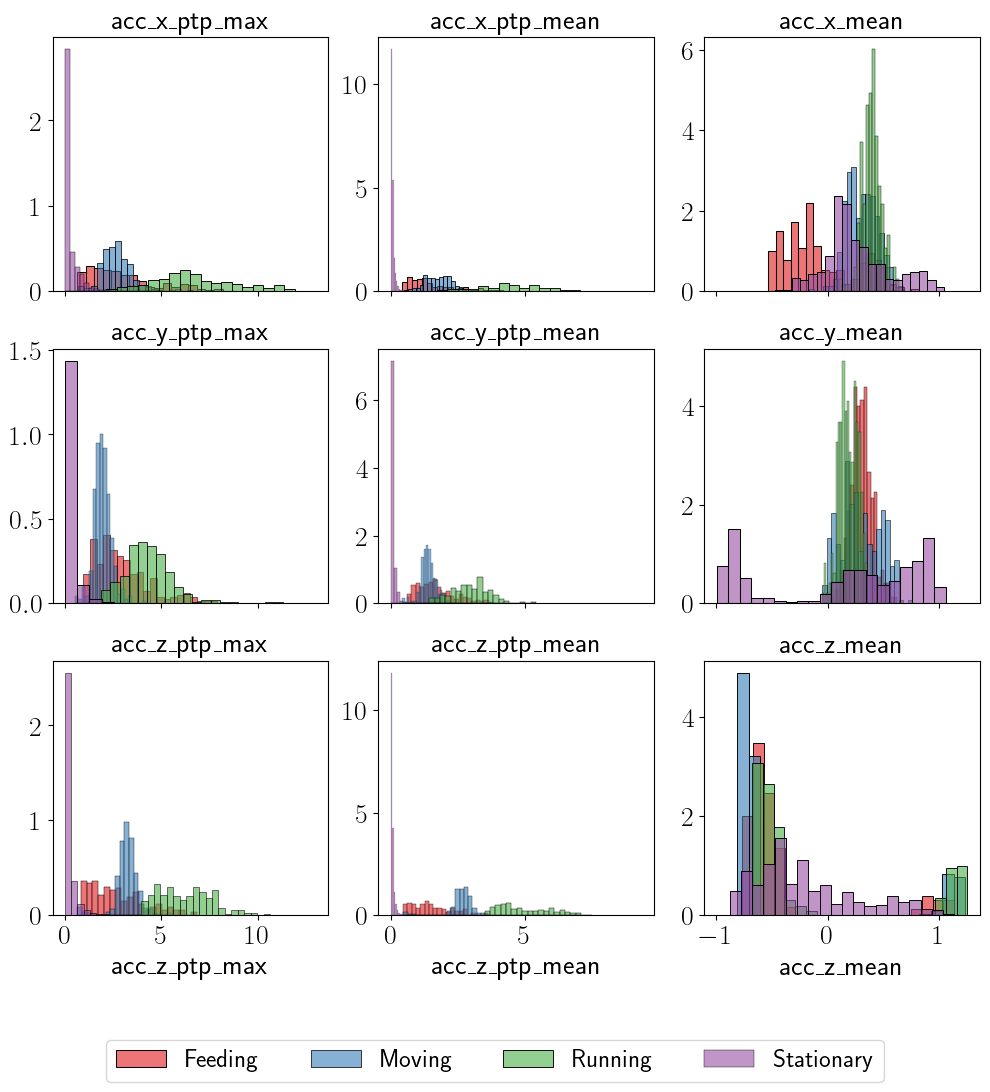

In [74]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(config.SUMMARY_BEHAVIORS))

behaviors_to_plot = summary_acc_data['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean', 'mean']

for i, axis in enumerate(acc_axes):
    for j, feature in enumerate(features):

        feature = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(config.SUMMARY_BEHAVIORS):
            sns.histplot(
                summary_acc_data[summary_acc_data['behavior'] == behavior][feature],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                bins=20,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_title(feature)
        ax.set_ylabel("")

# Place legend outside at the bottom center
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(config.SUMMARY_BEHAVIORS), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

## 2. Predict $Y \mid X$: Train Classification Model

In [75]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)

training_results_dir = os.path.join(get_results_dir(), 'summary_training_results')
os.makedirs(training_results_dir, exist_ok=True)

In [94]:
# train and model arguments

@dataclass
class TrainArgs:
    batch_size: int = 512
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False
    seed: int= 1

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [64])
    dropout_rate: float = 0.5

train_args = TrainArgs()
model_args = ModelArgs()

In [93]:
X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(summary_acc_data, feature_cols=feature_cols)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (4242, 9)
y_train: (4242,)
X_val: (1414, 9)
y_val: (1414,)
X_test: (1414, 9)
y_test: (1414,)


In [96]:
theta_list = np.round(0.1 * np.arange(11), 1)
seed_list = [1, 2, 3, 4, 5]

for theta in tqdm(theta_list, desc="Training models for different theta values"):
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        train_args.theta = theta
        train_args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(config.SUMMARY_BEHAVIORS), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{train_args.theta}_seed{train_args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
        

Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0365 | Val Loss: 0.0295 | Best val Loss: 0.0295: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]
Training models for different theta values:   0%|          | 0/11 [00:07<?, ?it/s]

Total training time: 0:00:07
Current theta: 0.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.0333 | Val Loss: 0.0257 | Best val Loss: 0.0257: 100%|██████████| 100/100 [00:06<00:00, 14.71it/s]
Training models for different theta values:   0%|          | 0/11 [00:14<?, ?it/s]

Total training time: 0:00:07
Current theta: 0.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.0405 | Val Loss: 0.0298 | Best val Loss: 0.0298: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]
Training models for different theta values:   0%|          | 0/11 [00:22<?, ?it/s]

Total training time: 0:00:08
Current theta: 0.0, Current seed: 4


Epoch 100/100 | Train Loss: 0.0406 | Val Loss: 0.0304 | Best val Loss: 0.0304: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]
Training models for different theta values:   0%|          | 0/11 [00:30<?, ?it/s]

Total training time: 0:00:08
Current theta: 0.0, Current seed: 5


Epoch 100/100 | Train Loss: 0.0367 | Val Loss: 0.0253 | Best val Loss: 0.0253: 100%|██████████| 100/100 [00:08<00:00, 12.23it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:38<06:22, 38.26s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 1


Epoch 100/100 | Train Loss: 0.0492 | Val Loss: 0.0236 | Best val Loss: 0.0236: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:45<06:22, 38.26s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 2


Epoch 100/100 | Train Loss: 0.0474 | Val Loss: 0.0215 | Best val Loss: 0.0215: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:53<06:22, 38.26s/it]

Total training time: 0:00:07
Current theta: 0.1, Current seed: 3


Epoch 100/100 | Train Loss: 0.0448 | Val Loss: 0.0230 | Best val Loss: 0.0230: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]
Training models for different theta values:   9%|▉         | 1/11 [01:01<06:22, 38.26s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 4


Epoch 100/100 | Train Loss: 0.0477 | Val Loss: 0.0244 | Best val Loss: 0.0244: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]
Training models for different theta values:   9%|▉         | 1/11 [01:09<06:22, 38.26s/it]

Total training time: 0:00:08
Current theta: 0.1, Current seed: 5


Epoch 100/100 | Train Loss: 0.0435 | Val Loss: 0.0214 | Best val Loss: 0.0214: 100%|██████████| 100/100 [00:06<00:00, 14.49it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:15<05:41, 37.94s/it]

Total training time: 0:00:07
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0509 | Val Loss: 0.0213 | Best val Loss: 0.0213: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:23<05:41, 37.94s/it]

Total training time: 0:00:07
Current theta: 0.2, Current seed: 2


Epoch 100/100 | Train Loss: 0.0564 | Val Loss: 0.0191 | Best val Loss: 0.0191: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:30<05:41, 37.94s/it]

Total training time: 0:00:08
Current theta: 0.2, Current seed: 3


Epoch 100/100 | Train Loss: 0.0503 | Val Loss: 0.0207 | Best val Loss: 0.0207: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:38<05:41, 37.94s/it]

Total training time: 0:00:08
Current theta: 0.2, Current seed: 4


Epoch 100/100 | Train Loss: 0.0559 | Val Loss: 0.0215 | Best val Loss: 0.0215: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]
Training models for different theta values:  18%|█▊        | 2/11 [01:46<05:41, 37.94s/it]

Total training time: 0:00:08
Current theta: 0.2, Current seed: 5


Epoch 100/100 | Train Loss: 0.0522 | Val Loss: 0.0189 | Best val Loss: 0.0189: 100%|██████████| 100/100 [00:08<00:00, 12.48it/s]
Training models for different theta values:  27%|██▋       | 3/11 [01:54<05:05, 38.23s/it]

Total training time: 0:00:08
Current theta: 0.3, Current seed: 1


Epoch 100/100 | Train Loss: 0.0583 | Val Loss: 0.0190 | Best val Loss: 0.0190: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]
Training models for different theta values:  27%|██▋       | 3/11 [02:02<05:05, 38.23s/it]

Total training time: 0:00:08
Current theta: 0.3, Current seed: 2


Epoch 100/100 | Train Loss: 0.0561 | Val Loss: 0.0174 | Best val Loss: 0.0174: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]
Training models for different theta values:  27%|██▋       | 3/11 [02:10<05:05, 38.23s/it]

Total training time: 0:00:08
Current theta: 0.3, Current seed: 3


Epoch 100/100 | Train Loss: 0.0549 | Val Loss: 0.0193 | Best val Loss: 0.0193: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]
Training models for different theta values:  27%|██▋       | 3/11 [02:18<05:05, 38.23s/it]

Total training time: 0:00:08
Current theta: 0.3, Current seed: 4


Epoch 100/100 | Train Loss: 0.0622 | Val Loss: 0.0188 | Best val Loss: 0.0188: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]
Training models for different theta values:  27%|██▋       | 3/11 [02:24<05:05, 38.23s/it]

Total training time: 0:00:07
Current theta: 0.3, Current seed: 5


Epoch 100/100 | Train Loss: 0.0554 | Val Loss: 0.0172 | Best val Loss: 0.0172: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:32<04:26, 38.01s/it]

Total training time: 0:00:07
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.0635 | Val Loss: 0.0176 | Best val Loss: 0.0176: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:39<04:26, 38.01s/it]

Total training time: 0:00:08
Current theta: 0.4, Current seed: 2


Epoch 100/100 | Train Loss: 0.0600 | Val Loss: 0.0159 | Best val Loss: 0.0158: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:47<04:26, 38.01s/it]

Total training time: 0:00:07
Current theta: 0.4, Current seed: 3


Epoch 100/100 | Train Loss: 0.0586 | Val Loss: 0.0171 | Best val Loss: 0.0171: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]
Training models for different theta values:  36%|███▋      | 4/11 [02:55<04:26, 38.01s/it]

Total training time: 0:00:08
Current theta: 0.4, Current seed: 4


Epoch 100/100 | Train Loss: 0.0608 | Val Loss: 0.0180 | Best val Loss: 0.0179: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]
Training models for different theta values:  36%|███▋      | 4/11 [03:03<04:26, 38.01s/it]

Total training time: 0:00:08
Current theta: 0.4, Current seed: 5


Epoch 100/100 | Train Loss: 0.0634 | Val Loss: 0.0159 | Best val Loss: 0.0159: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:10<03:48, 38.13s/it]

Total training time: 0:00:07
Current theta: 0.5, Current seed: 1


Epoch 100/100 | Train Loss: 0.0654 | Val Loss: 0.0164 | Best val Loss: 0.0164: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:18<03:48, 38.13s/it]

Total training time: 0:00:07
Current theta: 0.5, Current seed: 2


Epoch 100/100 | Train Loss: 0.0608 | Val Loss: 0.0149 | Best val Loss: 0.0149: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:25<03:48, 38.13s/it]

Total training time: 0:00:08
Current theta: 0.5, Current seed: 3


Epoch 100/100 | Train Loss: 0.0632 | Val Loss: 0.0159 | Best val Loss: 0.0159: 100%|██████████| 100/100 [00:07<00:00, 14.14it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:32<03:48, 38.13s/it]

Total training time: 0:00:07
Current theta: 0.5, Current seed: 4


Epoch 100/100 | Train Loss: 0.0657 | Val Loss: 0.0181 | Best val Loss: 0.0181: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]
Training models for different theta values:  45%|████▌     | 5/11 [03:40<03:48, 38.13s/it]

Total training time: 0:00:08
Current theta: 0.5, Current seed: 5


Epoch 100/100 | Train Loss: 0.0645 | Val Loss: 0.0145 | Best val Loss: 0.0145: 100%|██████████| 100/100 [00:07<00:00, 14.07it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:47<03:09, 37.84s/it]

Total training time: 0:00:07
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.0683 | Val Loss: 0.0154 | Best val Loss: 0.0154: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [03:55<03:09, 37.84s/it]

Total training time: 0:00:07
Current theta: 0.6, Current seed: 2


Epoch 100/100 | Train Loss: 0.0661 | Val Loss: 0.0139 | Best val Loss: 0.0139: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [04:02<03:09, 37.84s/it]

Total training time: 0:00:08
Current theta: 0.6, Current seed: 3


Epoch 100/100 | Train Loss: 0.0719 | Val Loss: 0.0163 | Best val Loss: 0.0163: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [04:10<03:09, 37.84s/it]

Total training time: 0:00:08
Current theta: 0.6, Current seed: 4


Epoch 100/100 | Train Loss: 0.0699 | Val Loss: 0.0167 | Best val Loss: 0.0167: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [04:17<03:09, 37.84s/it]

Total training time: 0:00:07
Current theta: 0.6, Current seed: 5


Epoch 100/100 | Train Loss: 0.0643 | Val Loss: 0.0143 | Best val Loss: 0.0143: 100%|██████████| 100/100 [00:06<00:00, 14.95it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:24<02:29, 37.49s/it]

Total training time: 0:00:07
Current theta: 0.7, Current seed: 1


Epoch 100/100 | Train Loss: 0.0714 | Val Loss: 0.0144 | Best val Loss: 0.0144: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:32<02:29, 37.49s/it]

Total training time: 0:00:07
Current theta: 0.7, Current seed: 2


Epoch 100/100 | Train Loss: 0.0680 | Val Loss: 0.0137 | Best val Loss: 0.0137: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:39<02:29, 37.49s/it]

Total training time: 0:00:08
Current theta: 0.7, Current seed: 3


Epoch 100/100 | Train Loss: 0.0702 | Val Loss: 0.0162 | Best val Loss: 0.0162: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:47<02:29, 37.49s/it]

Total training time: 0:00:08
Current theta: 0.7, Current seed: 4


Epoch 100/100 | Train Loss: 0.0696 | Val Loss: 0.0169 | Best val Loss: 0.0169: 100%|██████████| 100/100 [00:08<00:00, 12.37it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [04:55<02:29, 37.49s/it]

Total training time: 0:00:08
Current theta: 0.7, Current seed: 5


Epoch 100/100 | Train Loss: 0.0724 | Val Loss: 0.0140 | Best val Loss: 0.0140: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [05:04<01:54, 38.19s/it]

Total training time: 0:00:09
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.0738 | Val Loss: 0.0145 | Best val Loss: 0.0144: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [05:12<01:54, 38.19s/it]

Total training time: 0:00:08
Current theta: 0.8, Current seed: 2


Epoch 100/100 | Train Loss: 0.0654 | Val Loss: 0.0133 | Best val Loss: 0.0133: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [05:20<01:54, 38.19s/it]

Total training time: 0:00:08
Current theta: 0.8, Current seed: 3


Epoch 100/100 | Train Loss: 0.0803 | Val Loss: 0.0171 | Best val Loss: 0.0171: 100%|██████████| 100/100 [00:06<00:00, 14.96it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [05:27<01:54, 38.19s/it]

Total training time: 0:00:07
Current theta: 0.8, Current seed: 4


Epoch 100/100 | Train Loss: 0.0758 | Val Loss: 0.0180 | Best val Loss: 0.0180: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [05:35<01:54, 38.19s/it]

Total training time: 0:00:08
Current theta: 0.8, Current seed: 5


Epoch 100/100 | Train Loss: 0.0701 | Val Loss: 0.0142 | Best val Loss: 0.0142: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [05:44<01:17, 38.68s/it]

Total training time: 0:00:08
Current theta: 0.9, Current seed: 1


Epoch 100/100 | Train Loss: 0.0762 | Val Loss: 0.0168 | Best val Loss: 0.0168: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [05:51<01:17, 38.68s/it]

Total training time: 0:00:07
Current theta: 0.9, Current seed: 2


Epoch 100/100 | Train Loss: 0.0702 | Val Loss: 0.0143 | Best val Loss: 0.0143: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [05:58<01:17, 38.68s/it]

Total training time: 0:00:08
Current theta: 0.9, Current seed: 3


Epoch 100/100 | Train Loss: 0.0756 | Val Loss: 0.0183 | Best val Loss: 0.0182: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [06:06<01:17, 38.68s/it]

Total training time: 0:00:08
Current theta: 0.9, Current seed: 4


Epoch 100/100 | Train Loss: 0.0799 | Val Loss: 0.0182 | Best val Loss: 0.0182: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [06:14<01:17, 38.68s/it]

Total training time: 0:00:07
Current theta: 0.9, Current seed: 5


Epoch 100/100 | Train Loss: 0.0762 | Val Loss: 0.0158 | Best val Loss: 0.0158: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]
Training models for different theta values:  91%|█████████ | 10/11 [06:21<00:38, 38.39s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0794 | Val Loss: 0.0180 | Best val Loss: 0.0180: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]
Training models for different theta values:  91%|█████████ | 10/11 [06:30<00:38, 38.39s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 2


Epoch 100/100 | Train Loss: 0.0716 | Val Loss: 0.0163 | Best val Loss: 0.0161: 100%|██████████| 100/100 [00:06<00:00, 15.80it/s]
Training models for different theta values:  91%|█████████ | 10/11 [06:36<00:38, 38.39s/it]

Total training time: 0:00:06
Current theta: 1.0, Current seed: 3


Epoch 100/100 | Train Loss: 0.0766 | Val Loss: 0.0206 | Best val Loss: 0.0206: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]
Training models for different theta values:  91%|█████████ | 10/11 [06:43<00:38, 38.39s/it]

Total training time: 0:00:07
Current theta: 1.0, Current seed: 4


Epoch 100/100 | Train Loss: 0.0817 | Val Loss: 0.0191 | Best val Loss: 0.0191: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]
Training models for different theta values:  91%|█████████ | 10/11 [06:51<00:38, 38.39s/it]

Total training time: 0:00:08
Current theta: 1.0, Current seed: 5


Epoch 100/100 | Train Loss: 0.0770 | Val Loss: 0.0180 | Best val Loss: 0.0180: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]
Training models for different theta values: 100%|██████████| 11/11 [06:58<00:00, 38.08s/it]

Total training time: 0:00:08


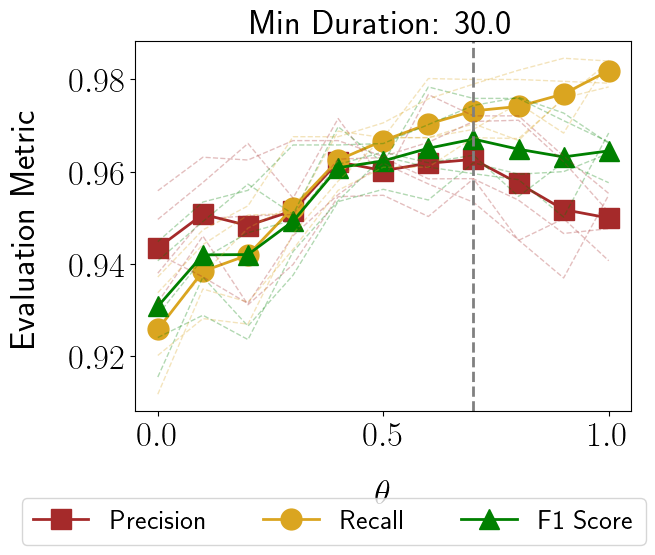

In [103]:
colors = ['brown', 'goldenrod', 'green']
theta_list = np.round(0.1 * np.arange(11), 1)
seed_list = [1, 2, 3, 4, 5]

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)

plt.axvline(x=0.7, linestyle='--', color='grey', linewidth=2,)
plt.title(f"Min Duration: {window_duration}")
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.4))
# plt.tight_layout()
plt.show()  

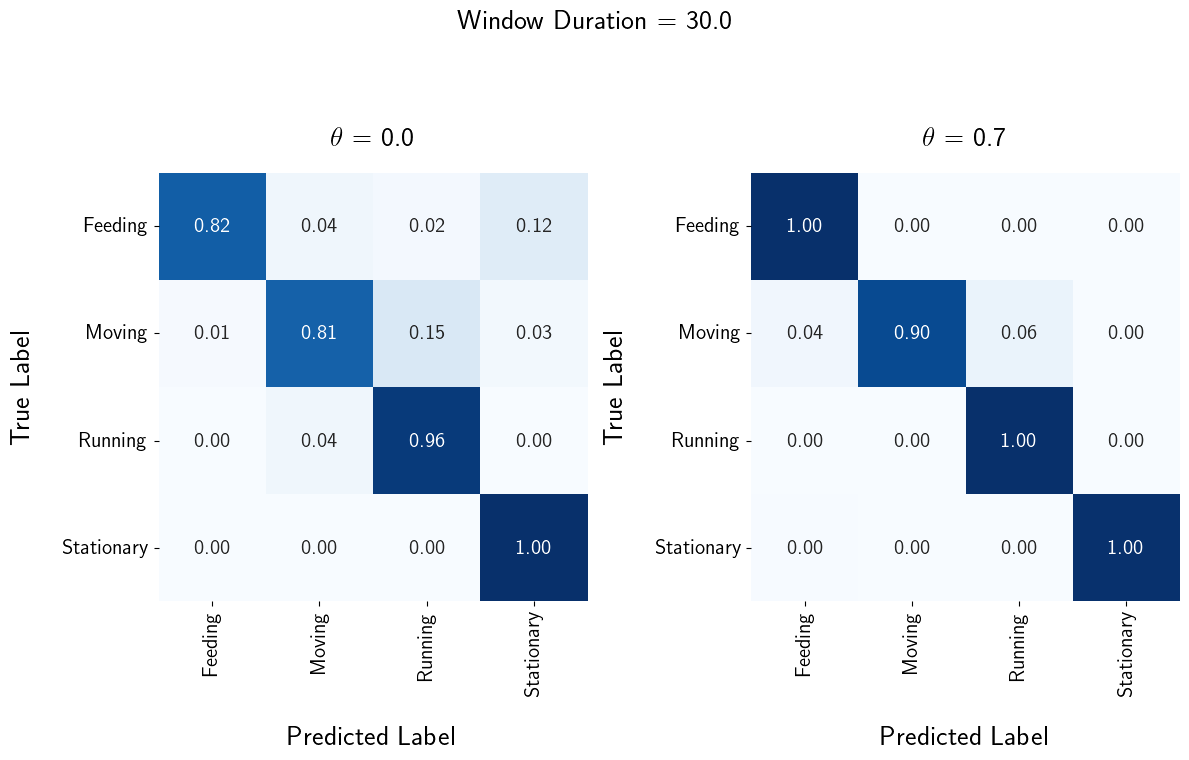

In [107]:
theta_list = [0.0, 0.7]
seed_star = 3
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}_seed{seed_star}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"$\\theta$ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {window_duration}", fontsize=20)
plt.tight_layout()
plt.show()

## 3. Test the Model on Summaries on 20 seconds

In [108]:
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=20.0, sampling_rate=config.SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 20.0]
summary_acc_data_20 = create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE)

X = summary_acc_data_20[feature_cols].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(summary_acc_data_20['behavior'])

In [111]:
window_duration_star, theta_star = 30.0, 0.7
model_dir = os.path.join(training_results_dir, f"duration{window_duration_star}_theta{theta_star}_seed{seed_star}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [112]:
with torch.no_grad():
    y_pred = torch.argmax(model(torch.tensor(X, dtype=torch.float32).to(device)), dim=1)

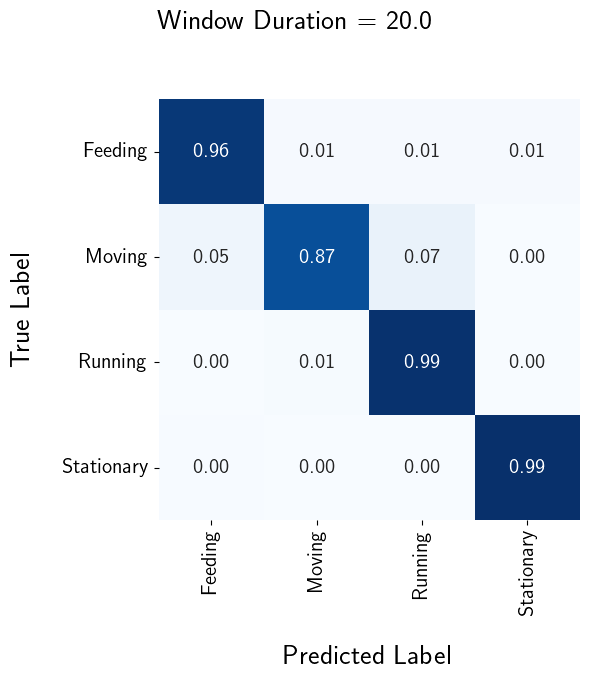

In [113]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 7))

cm = confusion_matrix(y, y_pred.detach().cpu().numpy(), normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y))))

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
fig.suptitle(f"Window Duration = 20.0", fontsize=20)
plt.tight_layout()
plt.show()